In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/bev-generation


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [180]:
import numpy as np
import torch

import cv2

from nuscenes.nuscenes import NuScenes

from bev_map import generate_bev_map
from bev import generate_bev_seg_map

import nusc_utils

In [2]:
# Load NuScenes dataset
dataroot = '/Users/deepakduggirala/Documents/autonomous-robotics/v1.0-mini'  # os.path.expandvars(config.dataroot)
nuscenes = NuScenes('v1.0-mini', dataroot, verbose=False)

In [3]:
map_data = generate_bev_map(nuscenes, 0, 30)

/Users/deepakduggirala/miniforge3/envs/tim/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [4]:
map_data.shape

(15, 196, 200)

interpolating depth
interpolating segmentation classes
generating BEV projection


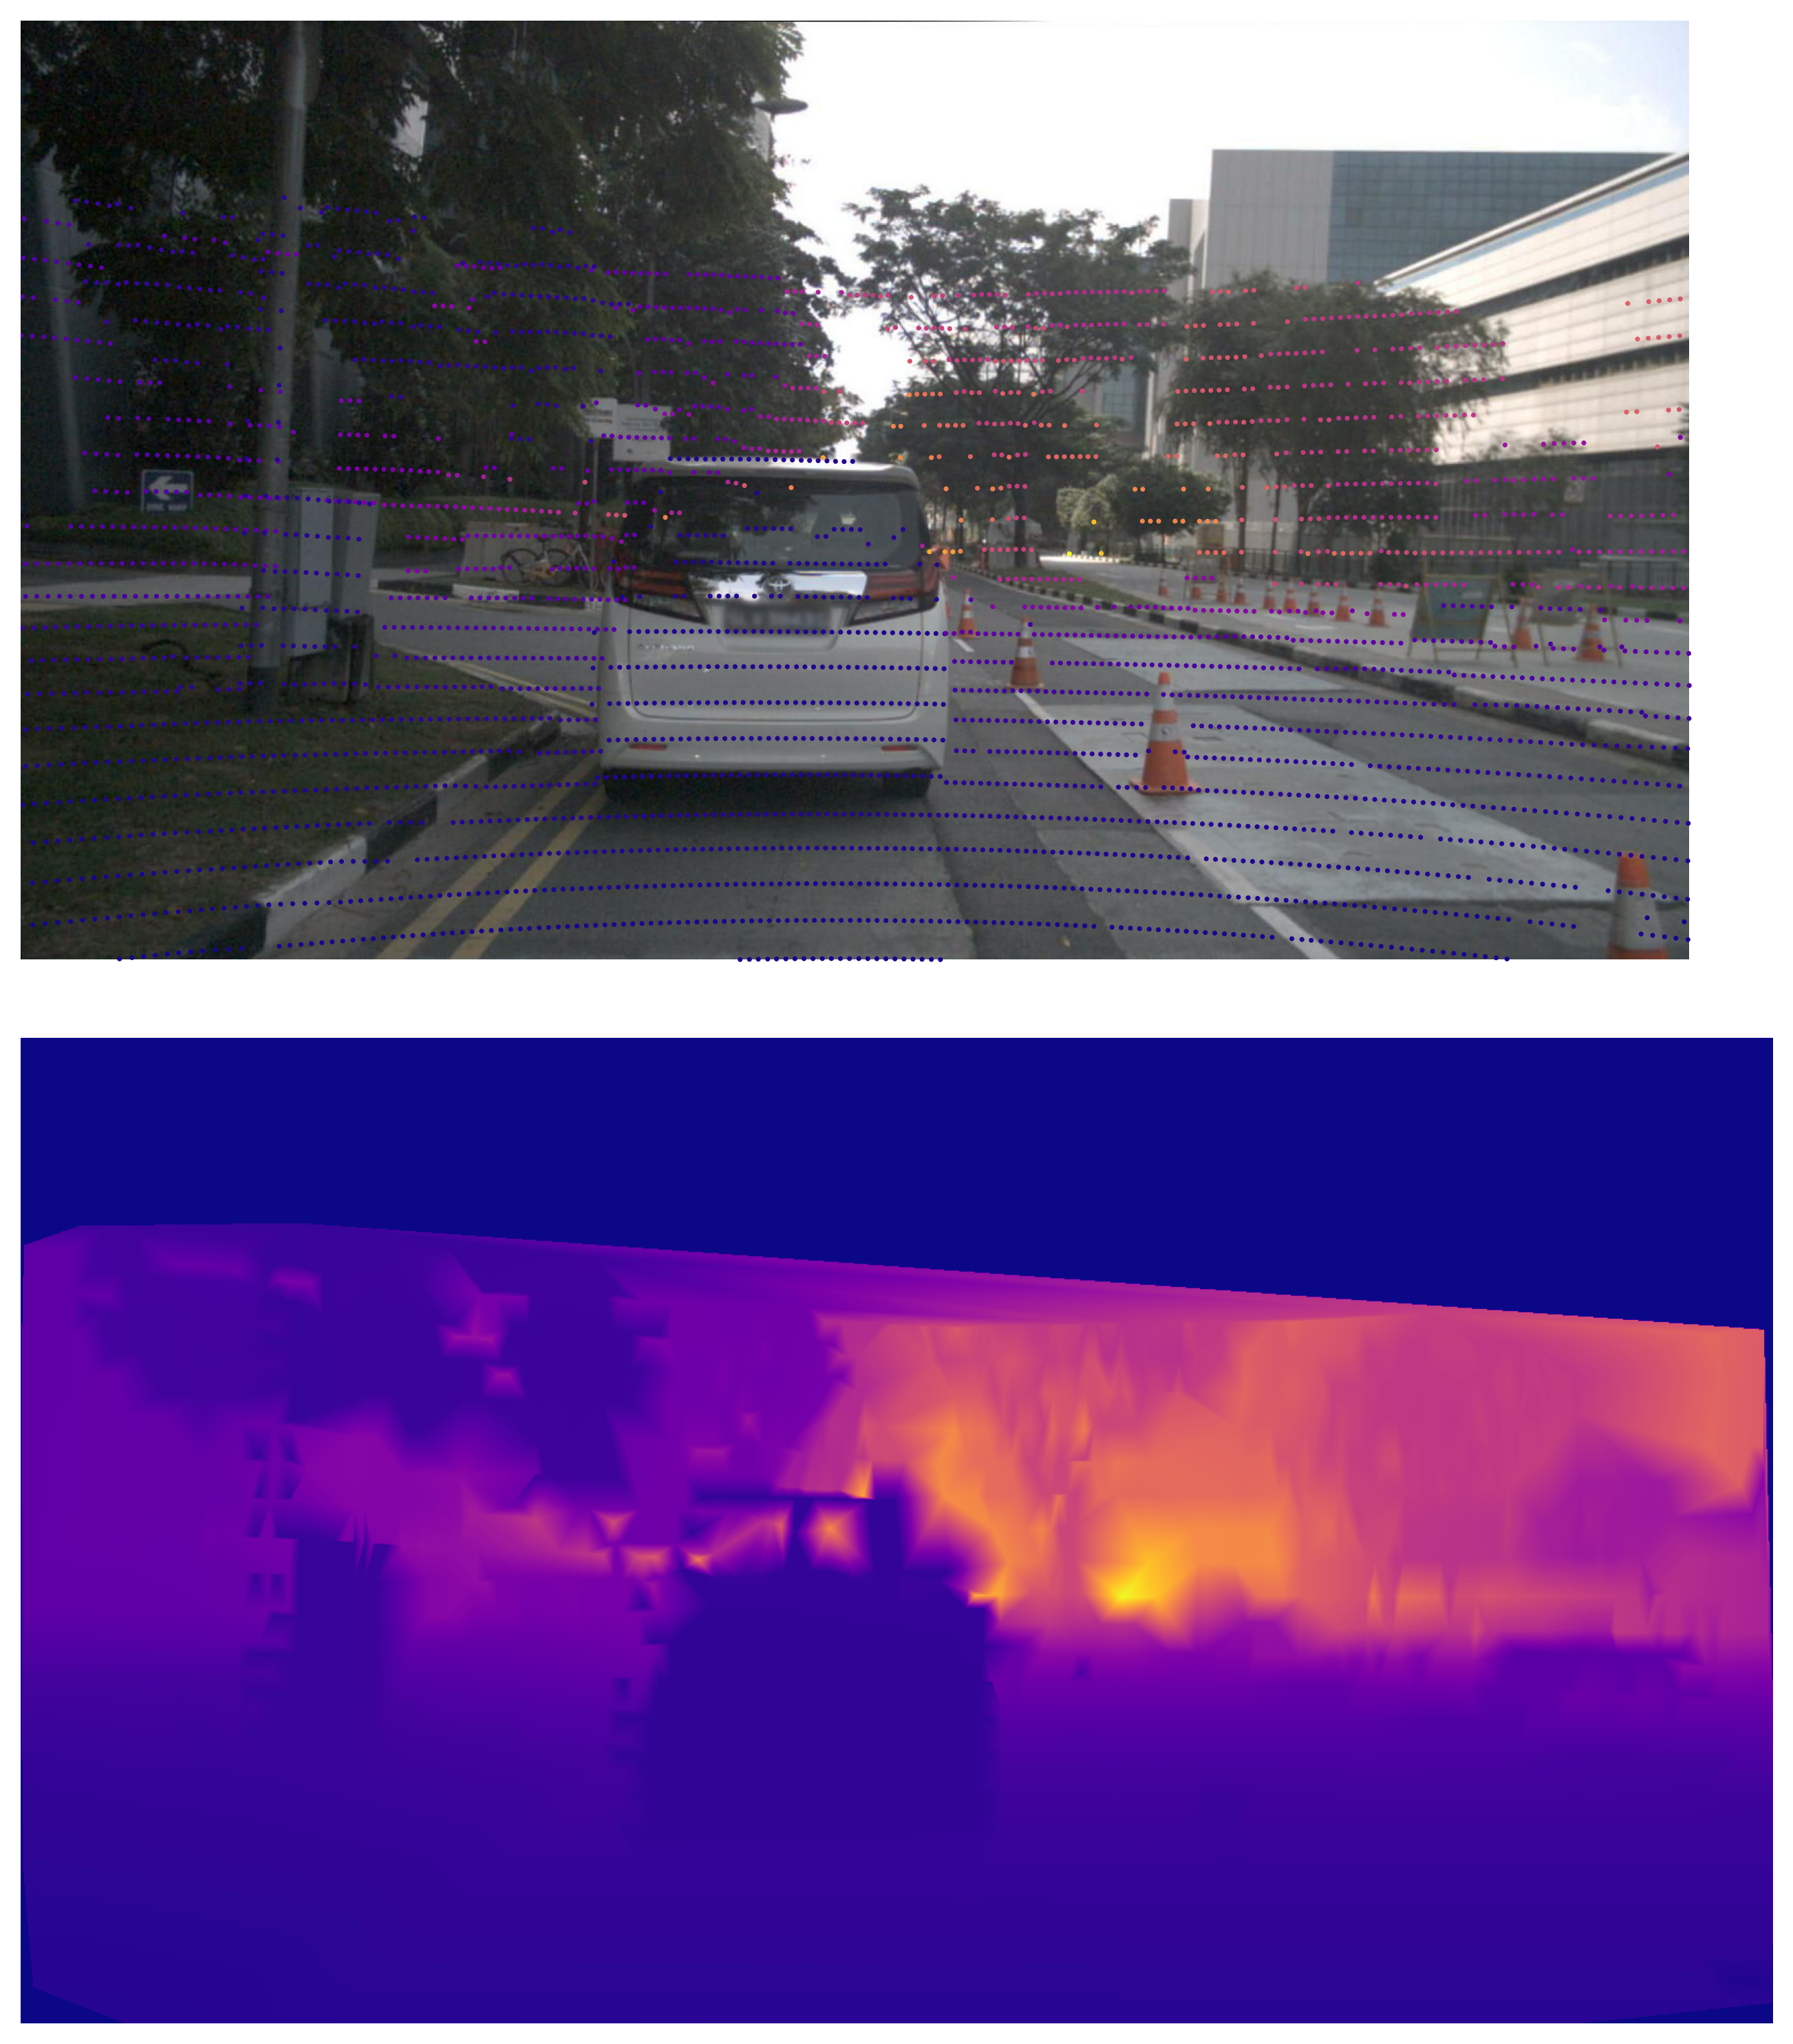

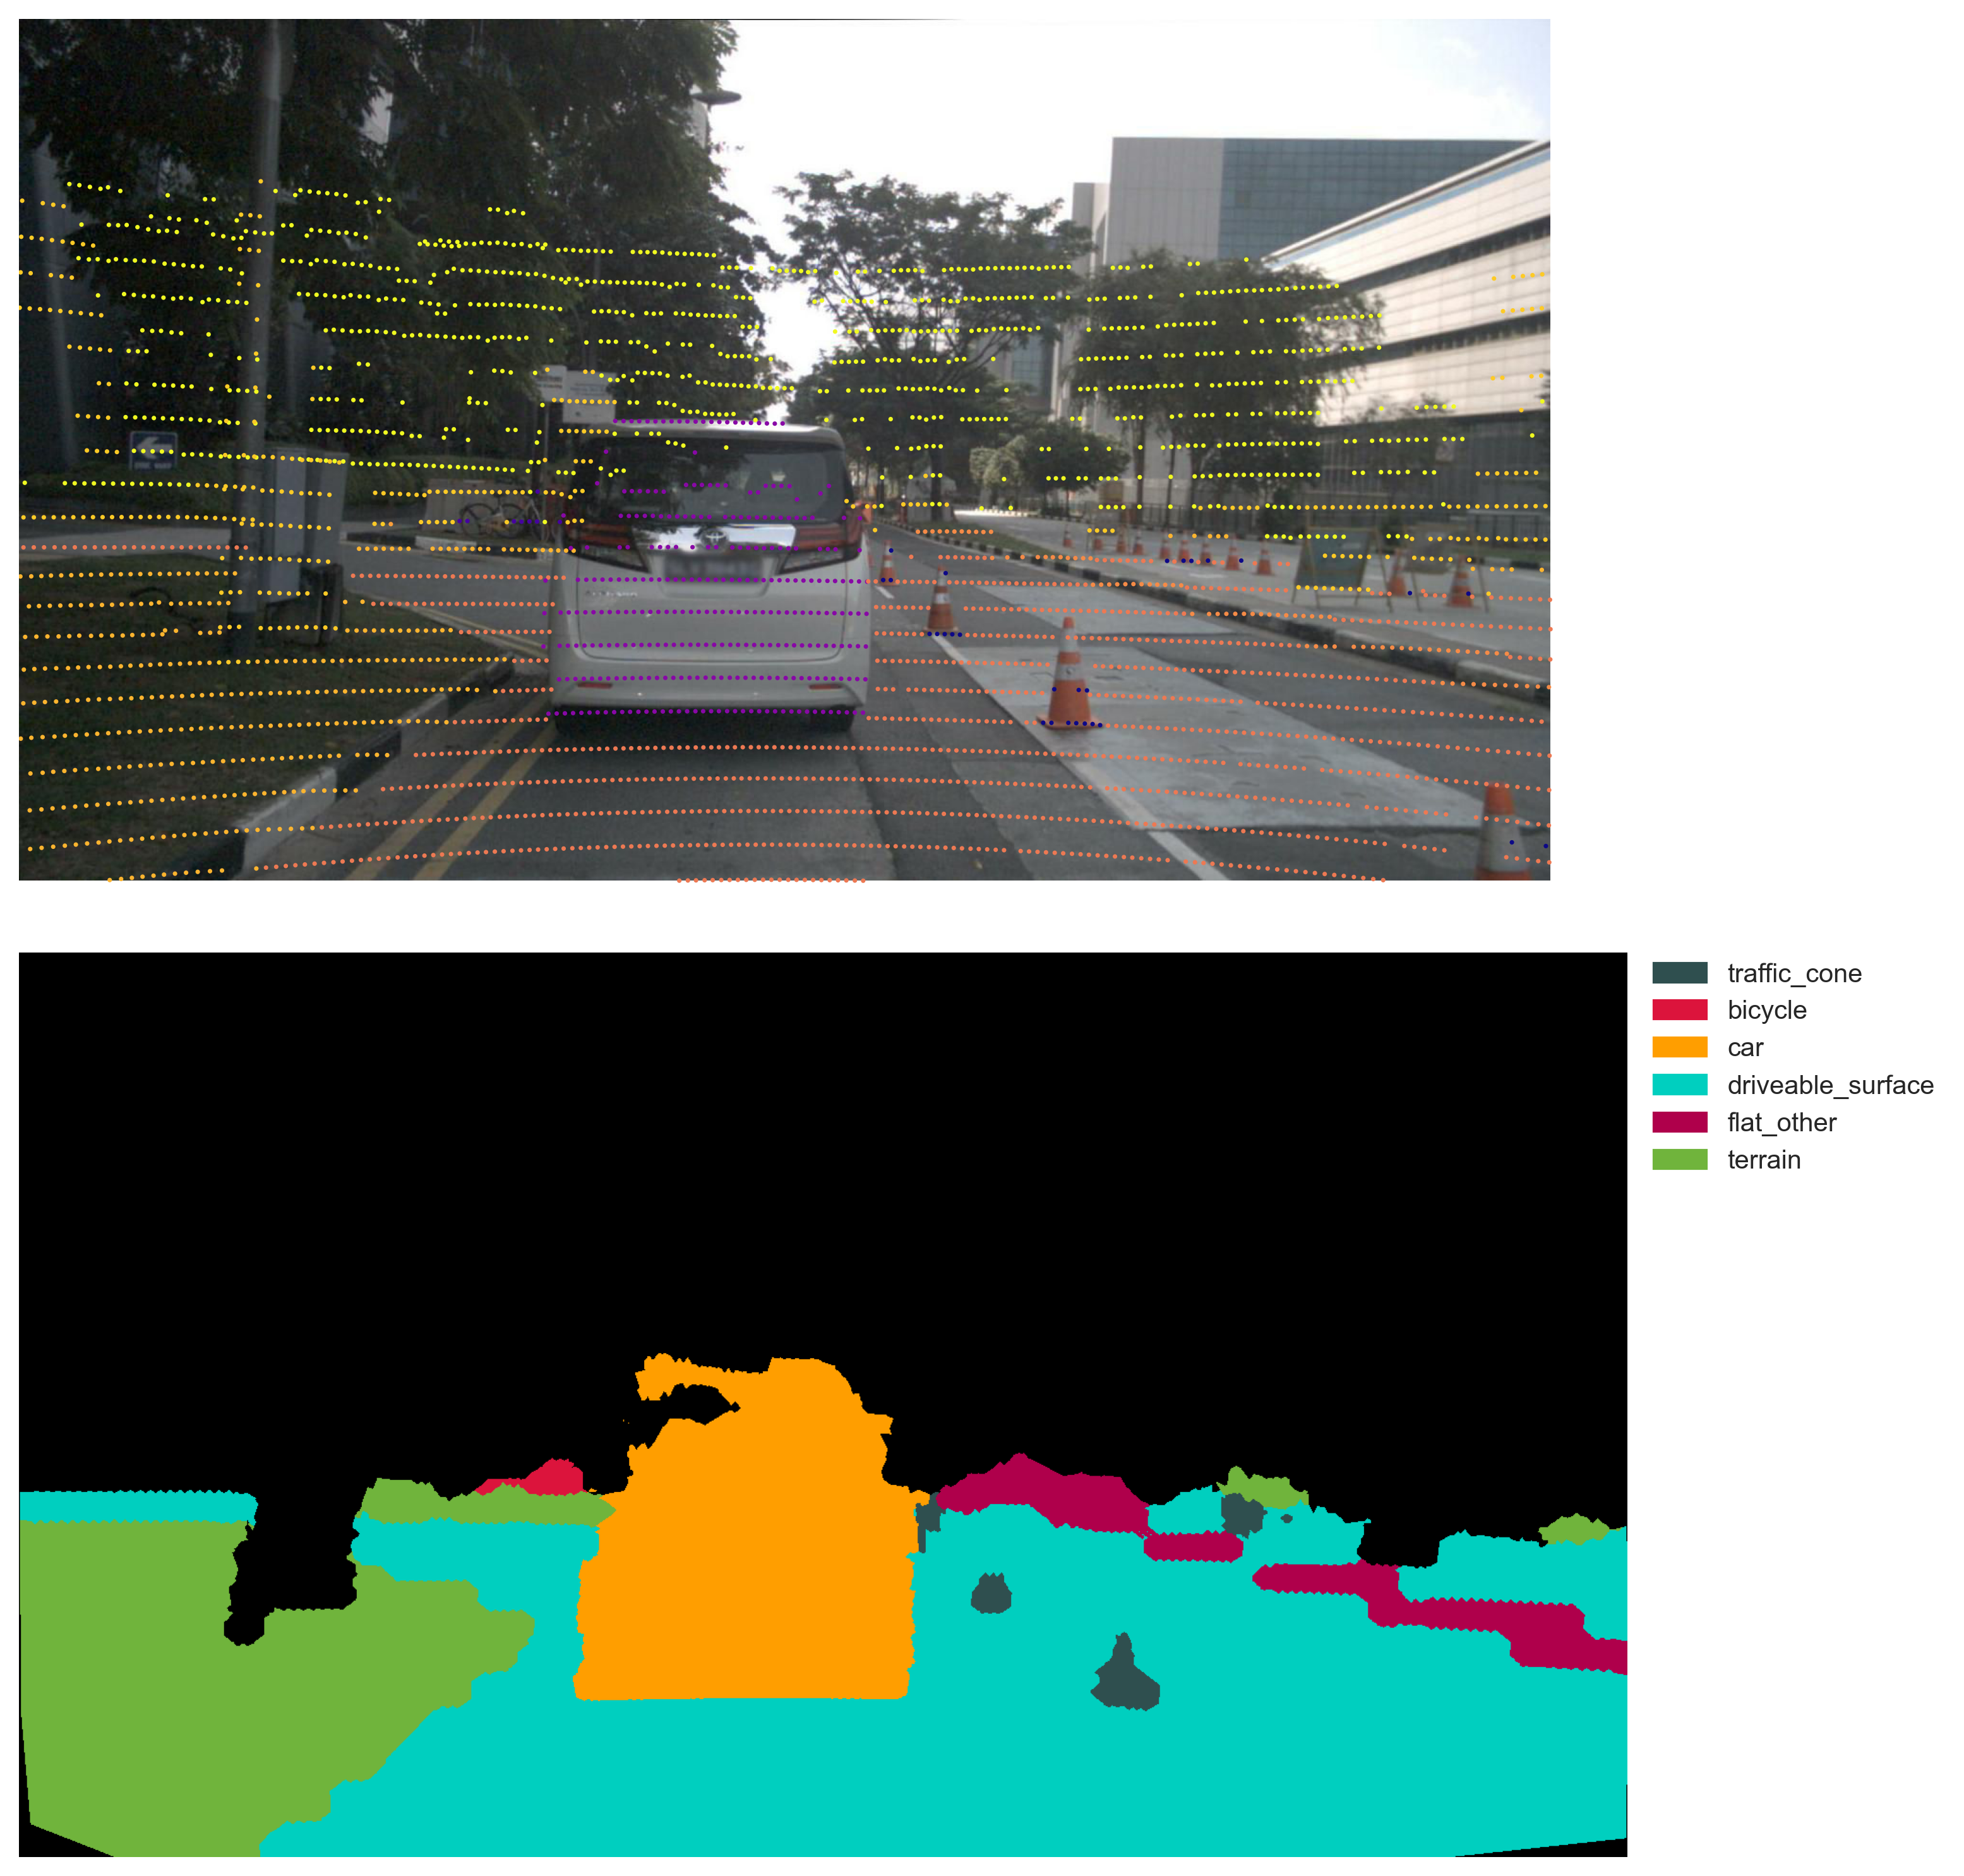

In [5]:
bev_seg_map, nusc_idx_to_color = generate_bev_seg_map(nuscenes, scene_idx=0, sample_idx=30)

In [6]:
bev_seg_map.shape

(14, 200, 200)

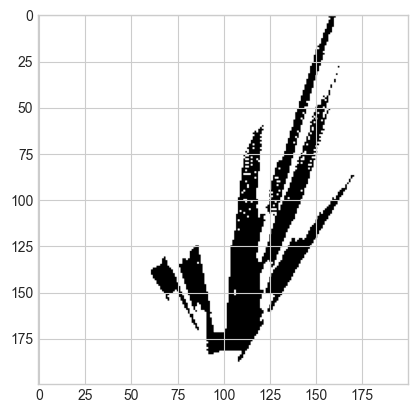

In [17]:
plt.imshow(bev_seg_map[0])

In [48]:
def make_composite(cls_maps):
    """
    cls_maps: Nc x h x w - boolean masks tensors
    Nc - number of classes - len(args.pred_classes_nusc)

    Output: h x w tensors where each pixel will have a class index
    """
    nc = cls_maps.shape[0]
    class_idx = np.arange(nc) + 1
    x = (cls_maps > 0.5).astype('float') * class_idx.reshape(-1, 1, 1)
    cls_map_composite = np.max(x, axis=0)
    return cls_map_composite

In [168]:
# idx_exc_1_2 = list(sorted(set(range(map_data.shape[0])) - {1,2}))
map_data_cmp = make_composite(map_data)

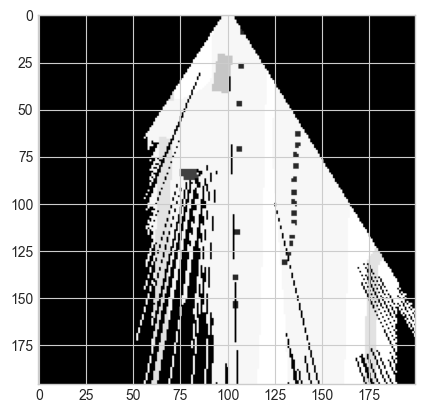

In [169]:
plt.imshow(map_data_cmp)

In [86]:
# idx_exc_1_2 = list(sorted(set(range(bev_seg_map.shape[0])) - {1,2}))
bev_seg_map_cmp = make_composite(bev_seg_map)

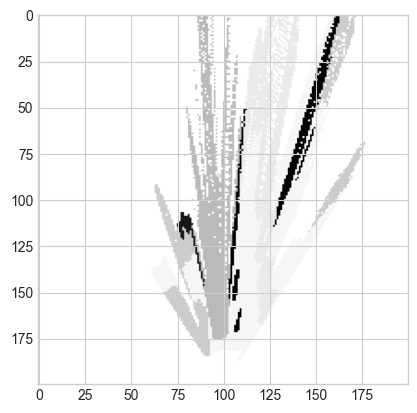

In [87]:
plt.imshow(bev_seg_map_cmp)

In [195]:
color_map = {i+1:c for i,c in nusc_idx_to_color.items()}
color_map[0] = [255, 255, 255]
color_map[2] = [255, 255, 255]
color_map[4] = [255, 255, 255]
color_map[15] = [255, 255, 255]
color_map

{1: (0, 207, 191),
 2: [255, 255, 255],
 3: (75, 0, 75),
 4: [255, 255, 255],
 5: (255, 158, 0),
 6: (255, 99, 71),
 7: (255, 69, 0),
 8: (255, 140, 0),
 9: (233, 150, 70),
 10: (138, 43, 226),
 11: (255, 61, 99),
 12: (220, 20, 60),
 13: (47, 79, 79),
 14: (112, 128, 144),
 0: [255, 255, 255],
 15: [255, 255, 255]}

In [196]:
def color_components(labels, color_map):
    """
    label 0 is assigned white color to have a white background.

    Iterates through the image to replace each pixel with the color associated with its label.

    Returns the colored image.
    """
    colors = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)    
    for idx in np.unique(labels).astype(int):
        ii, jj = np.where(labels == idx)
        colors[ii, jj, :] = np.array(color_map[idx])

    return colors

In [197]:
map_data_cmp_color = color_components(map_data_cmp, color_map=color_map)
bev_seg_map_cmp_color = color_components(bev_seg_map_cmp, color_map=color_map)

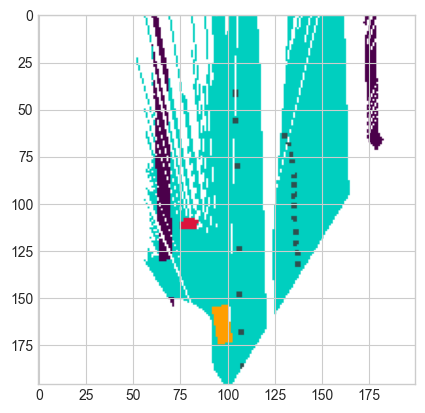

In [198]:
plt.imshow(cv2.flip(map_data_cmp_color,0))

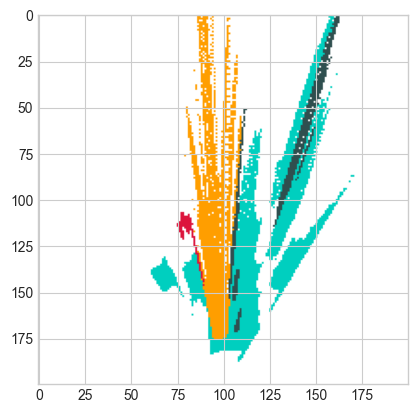

In [199]:
plt.imshow(bev_seg_map_cmp_color)

(-0.5, 199.5, 199.5, -0.5)

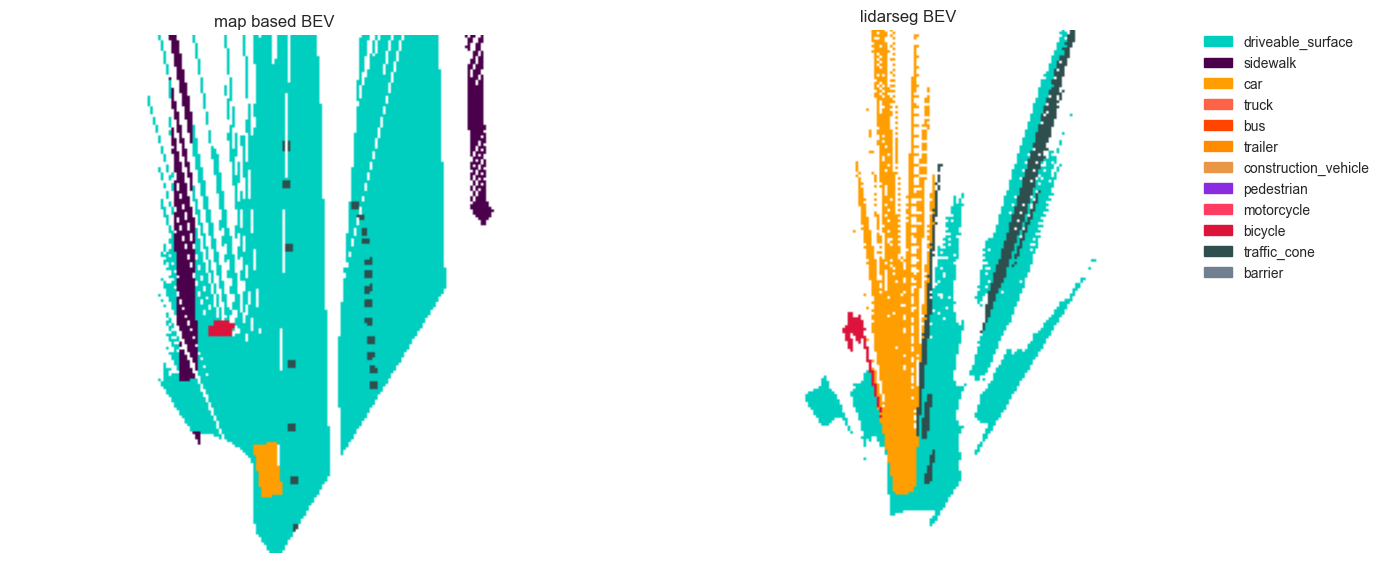

In [208]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
ax = axs[0]
ax.imshow(cv2.flip(map_data_cmp_color, 0))
ax.set_title('map based BEV')
ax.axis('off')

ax = axs[1]
ax.imshow(bev_seg_map_cmp_color)
ax.set_title('lidarseg BEV')

legend_colors = [np.append(np.array(nusc_idx_to_color[idx]) / 255, 1) for idx in range(len(nusc_idx_to_color))]
patches = [mpatches.Patch(color=legend_colors[i], label=label)
           for i, label in enumerate(nusc_utils.NUSC_LIDAR_CLASS_NAMES) if i not in [1, 3]]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('off')

In [210]:
len(nuscenes.scene)

10